# Loading Seasonal Forecasts from CDS

This notebook demonstrates how to load **seasonal forecasts** from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/how-to-api):
- Connect to the CDS API
- Request seasonal forecast data for a specific country and time period
- Visualize the data and compute zonal statistics

**Note:** For training purposes, we only load **one lead time (24h)** and **one year** to minimize runtime and data size. In practice, you can fetch **all lead times** and **multiple years**.

Additionally, you could compute **Standardized Precipitation Index (SPI)** or **drought probabilities** from the downloaded data.

## 1. Environment Setup

*You only need to run this cell once. If the library is already installed in your environment, you can skip this step.*

Install required packages. Ensure `cdsapi` is available for CDS API access.

In [ ]:
!pixi add cdsapi

## 2. Import Libraries
We use `cdsapi` for data retrieval, `xarray` for handling NetCDF files, and `odc.geo` for geospatial operations.

In [7]:
import os
if os.getcwd().split("\\")[-1] != "anticipatory-action":
    os.chdir("..")
print(os.getcwd())

import cdsapi
import xarray as xr
import pandas as pd
from odc.geo.xr import xr_reproject
from config.params import Params
from hip.analysis.aoi.analysis_area import AnalysisArea

C:\Users\amine.barkaoui\OneDrive - World Food Programme\Documents\GitHub\anticipatory-action


## 3. Define Parameters
- `country`: ISO code of the country
- `issue`: Month of forecast issuance
- `start_year`, `end_year`: Time range (we use only one year for speed)
- `data_path`, `output_path`: Paths for input/output

In [15]:
country = "ISO"  # Replace with ISO code of the country
issue = 12       # Forecast issue month (December)
start_year = 1981
end_year = 2025  # For training, we only use the last year

data_path = "."  # anticipatory-action directory
output_path = "."

## 4. Define Area of Interest (AOI)
We use `AnalysisArea` to get administrative boundaries and resolution.

In [3]:
area = AnalysisArea.from_admin_boundaries(
    iso3=country,
    admin_level=0,
    resolution=0.25,
)
shp = area.get_dataset([area.BASE_AREA_DATASET])

## 5. Connect to CDS API
Initialize the CDS API client.

In [4]:
client = cdsapi.Client()

2025-12-15 15:04:19,744 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


## 6. Prepare Data Request
We request **seasonal-original-single-levels** dataset from ECMWF system 51.

**Important:**
- We only request **one lead time (24h)** and **one year** for speed.
- You can extend this to all lead times and years.

In [8]:
dataset = "seasonal-original-single-levels"
request = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": ["total_precipitation"],
    "year": end_year,  # Uncomment this to load all years: [str(y) for y in range(start_year, end_year + 1)]
    "month": [str(issue)],
    "day": ["01"],
    "leadtime_hour": "24",  # Could be [str(lt) for lt in range(24, 5184, 24)] for all leadtimes
    "data_format": "netcdf",
    "area": [area.bbox[-1], area.bbox[0], area.bbox[1], area.bbox[2]]
}
target = f"{data_path}/data/zmb/zarr/2022/{issue}/ecmwf_cds_24h.nc"

## 7. Retrieve Data
This step downloads the NetCDF file from CDS in `{data_path}/data/zmb/zarr/{end_year}/{issue}/ecmwf_cds_24h.nc`

In [9]:
client.retrieve(dataset, request, target)

2025-12-15 15:05:59,332 INFO Request ID is ba89a364-9850-42bb-9bca-82bdd5a268f3
INFO:ecmwf.datastores.legacy_client:Request ID is ba89a364-9850-42bb-9bca-82bdd5a268f3
2025-12-15 15:05:59,400 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-15 15:06:09,240 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful
                                                                                                                                    

'./data/zmb/zarr/2022/12/ecmwf_cds_24h.nc'

## 8. Load and Inspect Data
Use `xarray` to open the NetCDF file and attach CRS.

In [10]:
da = xr.open_dataset(target).tp.rio.write_crs('epsg:4326')
date = pd.to_datetime(da.forecast_reference_time.values[0]).strftime('%Y-%m-%d')

C:\Users\amine.barkaoui\AppData\Local\Temp\ipykernel_20968\1413521792.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  da = xr.open_dataset(target).tp.rio.write_crs('epsg:4326')


In [14]:
da

<xarray.DataArray 'tp' (number: 51, forecast_reference_time: 1,
                        forecast_period: 1, latitude: 10, longitude: 12)> Size: 24kB
array([[[[[0.001673, ..., 0.001503],
          ...,
          [0.000623, ..., 0.004621]]]],



       ...,



       [[[[0.003464, ..., 0.000481],
          ...,
          [0.000352, ..., 0.003031]]]]], dtype=float32)
Coordinates:
  * number                   (number) int64 408B 0 1 2 3 4 5 ... 46 47 48 49 50
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2025...
  * forecast_period          (forecast_period) timedelta64[ns] 8B 1 days
  * latitude                 (latitude) float64 80B -9.079 -10.08 ... -18.08
  * longitude                (longitude) float64 96B 22.0 23.0 ... 32.0 32.99
    valid_time               datetime64[ns] 8B ...
    spatial_ref              int32 4B 0
Attributes: (12/33)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      120
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

## 9. Visualize Forecast
Display the forecast for the AOI at different resolutions.

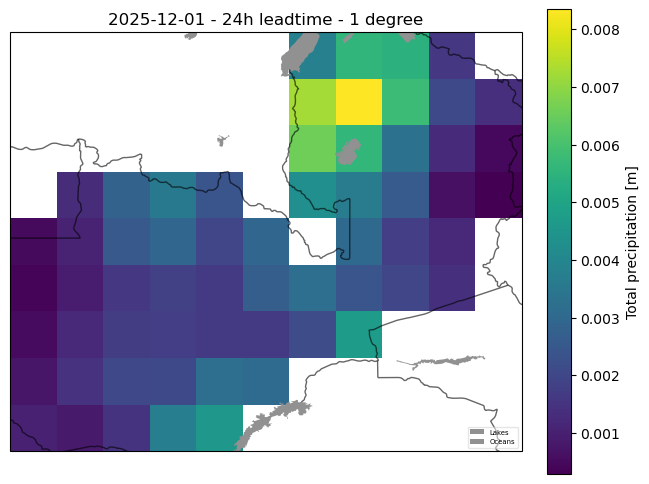

In [11]:
da.isel(forecast_reference_time=0, forecast_period=0, number=0).rio.write_crs('EPSG:4326').rio.clip(shp.geometry).hip.viz.map(
    title=f"{date} - 24h leadtime - 1 degree"
)

The following map shows the forecast at a 0.25 degree resolution. This forecast is obtained by reprojecting the native one using the bilinear interpolation method.

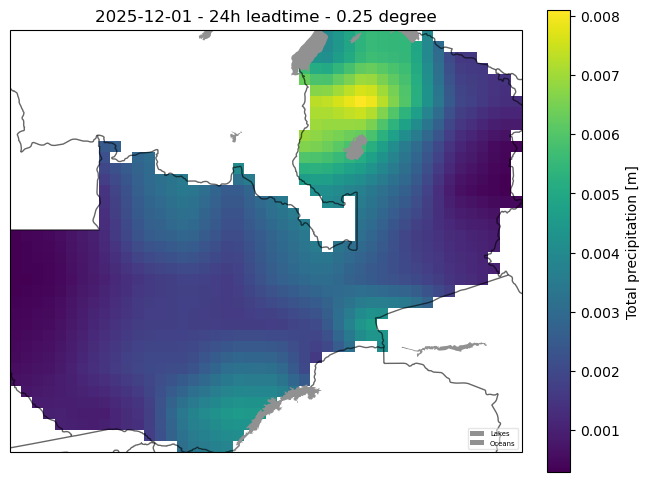

In [12]:
xr_reproject(da, area.geobox, resampling='bilinear').isel(forecast_reference_time=0, forecast_period=0, number=0).dropna('latitude', how='all').dropna('longitude', how='all').rio.clip(shp.geometry).hip.viz.map(
    title=f"{date} - 24h leadtime - 0.25 degree"
)

## 10. Compute Zonal Statistics
Aggregate forecast values by administrative boundaries (admin-2 level).

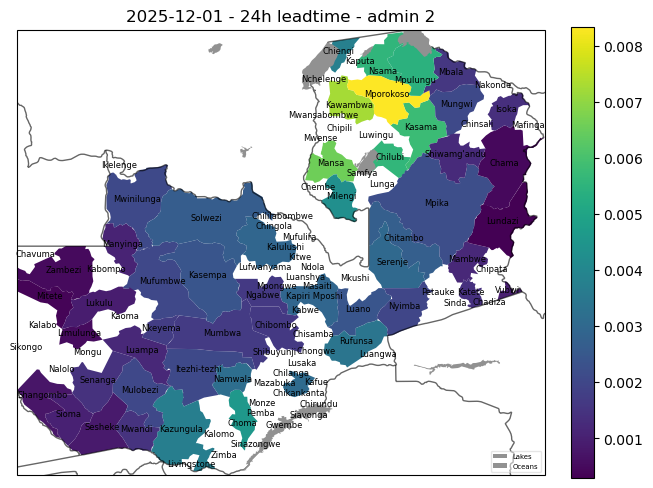

In [13]:
area = AnalysisArea.from_admin_boundaries(iso3=country, admin_level=2, resolution=0.25)
admin_fc = area.zonal_stats(da.isel(forecast_reference_time=0, forecast_period=0, number=0), stats=['mean']).reset_index().assign(time=date).set_index(['zone', 'time'])
zonal_gdf = area.join_zonal_stats(admin_fc['mean'])
zonal_gdf.hip.viz.map(title=f"{date} - 24h leadtime - admin 2", column=date, annotate='Name', legend=True)

## Next Steps
- Fetch all lead times and years for full analysis
- Adjust the format: convert cumulative rainfall to daily amounts
- Derive SPI and drought probabilities from complete dataset